## Machine Learning Coursework (Part 1)

For the coursework, please make sure to implement your own code and not use libraries (except where explicitly asked). You will need to present your own code that performs nested cross-validation and the k-nearest neighbour algorithm, build confusion matrices, and estimate distances between data samples.

The purpose of this coursework is to help you:

- Get familiar with **common python modules / functions** used for ML in python
- Get practical experience **implementing** ML methods in python
- Get practical experience regarding **parameter selection** for ML methods
- Get practical experience on **evaluating** ML methods and applying cross-validation

Notes:

- don't use libraries that implement kNN or cross-validation. We want to see your code!
- Remember to comment all of your code (see here for tips: https://stackabuse.com/commenting-python-code/). You can also make use of Jupyter Markdown, where appropriate, to improve the layout of your code and documentation.
- Please add docstrings to all of your functions (so that users can get information on inputs/outputs and what each function does by typing SHIFT+TAB over the function name. For more detail on python docstrings, see here: https://numpydoc.readthedocs.io/en/latest/format.html)
- When a question allows a free-form answer (e.g. what do you observe?), create a new markdown cell below and answer the question in the notebook.
- Always save your notebook when you are done (this is not automatic)!
- Upload your completed notebook using the VLE

Plagiarism: please make sure that the material you submit has been created by you. Any sources you use for code should be properly referenced. Your code will be checked for plagiarism using appropriate software.

### Marking

The grades in this coursework are allocated approximately as follows:

|                                                    | mark   |
| -------------------------------------------------- | ------ |
| Data exploration (+ 2 questions)                   | 10     |
| Code, docu. & comments (KNN + Evaluation + NCV)    | 10     |
| Results (KNN folds + Summary + Confusion matrices) | 10     |
| Final questions:                                   | 10     |
| Overall quality & use of Markdown                  | 10     |
| Total available                                    | **50** |


## 1. Exploratory Data Analysis

In this coursework we are going to be working with the **Wine** dataset. This is a 178 sample dataset that categorises 3 different types of Italian wine using 13 different features. The code below loads the Wine dataset and selects a subset of features for you to work with.


In [1]:
# set matplotlib backend to inline
%matplotlib inline 

# import modules
from sklearn import datasets 
import numpy as np 
import matplotlib.pyplot as plt 
import pandas as pd

# load data
wine=datasets.load_wine()
#print(wine.DESCR)

# this dataset has 13 features, we will only choose a subset of these
df_wine = pd.DataFrame(wine.data, columns = wine.feature_names)
selected_features = ['alcohol','flavanoids','color_intensity','ash']

# extract the data as numpy arrays of features, X, and target, y
X = df_wine[selected_features].values
y = wine.target

### 1.1. Visualising the data

The first part of tackling any ML problem is visualising the data in order to understand some of the properties of the problem at hand. When there are only a small number of classes and features, it is possible to use scatter plots to visualise interactions between different pairings of features.

The following image shows what such a visualisation might look like on the Iris dataset that you worked on during the Topic exercises.

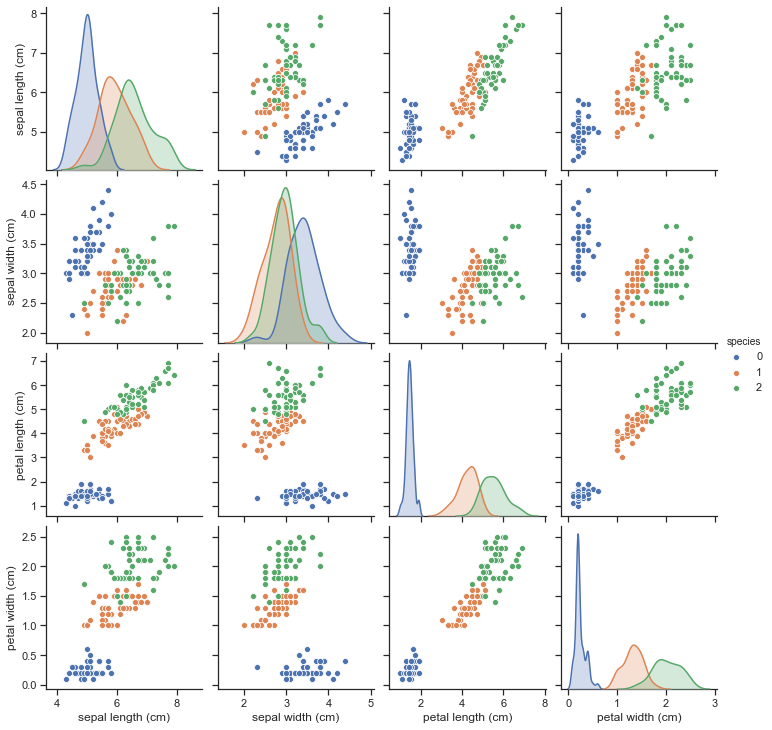

Your first task is to recreate a similar grid for the **Wine** dataset, with each off-diagonal subplot showing the interaction between two features, and each of the classes represented as a different colour. The on-diagonal subplots (representing a single feature) should show a distribution (or histogram) for that feature.

You should create a function that, given data X and labels y, plots this grid. The function should be invoked something like this:

    myplotGrid(X,y,...)

where X is your training data and y are the labels (you may also supply additional optional arguments). You can use an appropriate library to help you create the visualisation. You might want to code it yourself using matplotlib functions scatter and hist - however, this is not strictly necessary here, so try not spend too much time on this.


In [33]:
import pandas as pd
from matplotlib import cm as pltcm
from typing import List


def myplotGrid(
    X: np.ndarray, y: np.ndarray, feature_names: List[str], alpha: float = 0.5
):
    """
    Plot pairwise relationships in a dataset.
    """
    cmap = pltcm.get_cmap("viridis")
    df = pd.DataFrame(X, columns=feature_names)
    axes = pd.plotting.scatter_matrix(
        df,
        figsize=(8, 8),
        range_padding=0.1,
        color=cmap(y / 2.0),
        marker="s",
        edgecolor="white",
        alpha=alpha,
    )

    corr = df.corr().values
    for i in range(len(feature_names)):
        for j in range(len(feature_names)):
            if i != j:
                ax = axes[i, j]
                ax.annotate(
                    f"corr={round(corr[i, j], 3)}",
                    (1, 0.95),
                    xycoords="axes fraction",
                    ha="right",
                    va="center",
                    fontsize=8,
                )

    for i in range(len(feature_names)):
        ax = axes[i, i]
        xlabel, ylabel = ax.get_xlabel(), ax.get_ylabel()
        ax.clear()
        ax.set_xlabel(xlabel)
        ax.set_ylabel(ylabel)
        for yi in sorted(np.unique(y)):
            ax.hist(
                X[y == yi, i],
                density=True,
                alpha=alpha,
                edgecolor="white",
                color=cmap(yi / 2.0),
            )


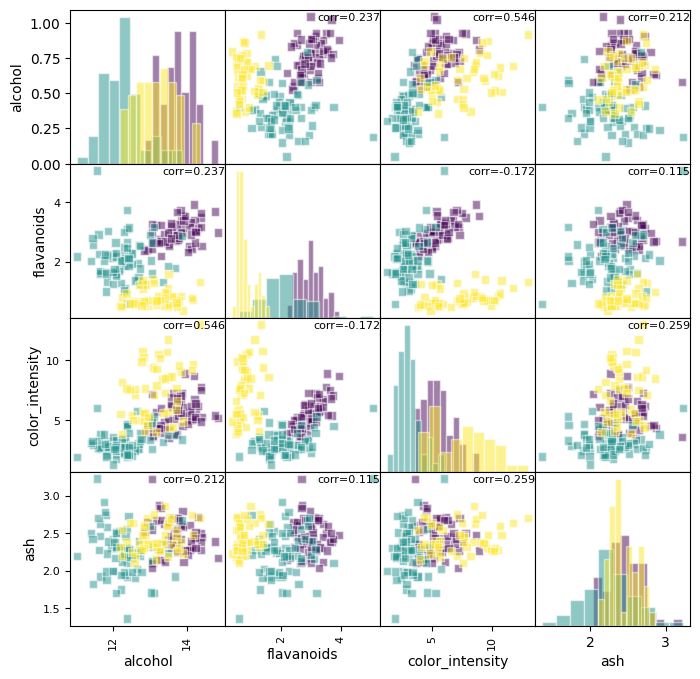

In [34]:
myplotGrid(X, y, feature_names=selected_features)


### 1.2. Exploratory Data Analysis under noise

When data are collected under real-world settings they usually contain some amount of noise that makes classification more challenging. In the cell below, invoke your exploratory data analysis function above on a noisy version of your data X.

Try to perturb your data with some Gaussian noise,

    # initialize random seed to replicate results over different runs
    mySeed = 12345
    np.random.seed(mySeed)
    XN=X+np.random.normal(0,0.6,X.shape)

and then invoke

    myplotGrid(XN,y)


In [35]:
r = 42
np.random.seed(r)
XN = X + np.random.normal(0, 0.6, X.shape)


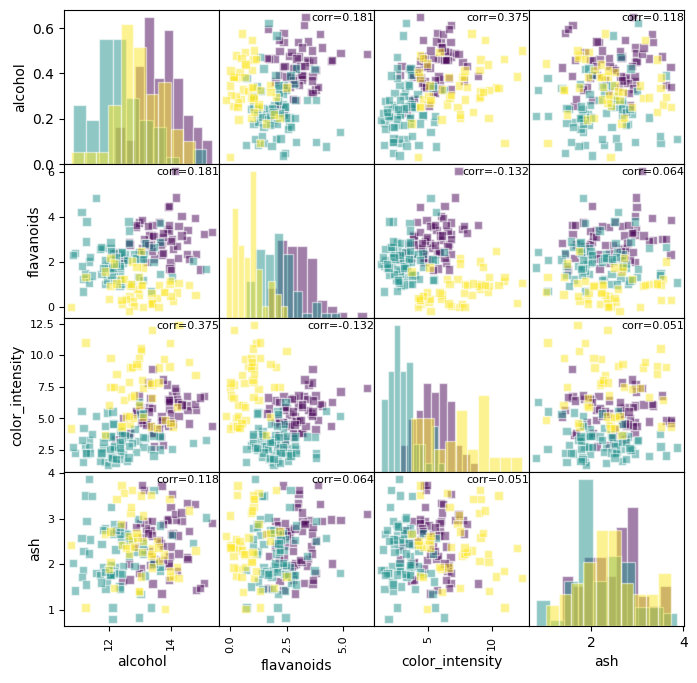

In [36]:
myplotGrid(XN, y, feature_names=selected_features)


### Q1. Exploratory data analysis

Based on your exploratory analysis, if you were to build a classifier using only two of the available features, which ones would you choose and why? Answer as fully as you can.


answer:


### Q2. Data with noise

What do you observe by plotting the data without noise compared to plotting with added Gaussian noise?


answer:


## 2. Implementing kNN

In the cell below, develop your own code for performing k-Nearest Neighbour classification. You may use the scikit-learn k-NN implementation from the labs as a guide - and as a way of verifying your results - but it is important that your implementation does not use any libraries other than the basic numpy and matplotlib functions.

Define a function that performs k-NN given a set of data. Your function should be invoked similary to:

        y_ = mykNN(X,y,X_,options)

where X is your training data, y is your training outputs, X\_ are your testing data and y\_ are your predicted outputs for X\_. The options argument (can be a list or a set of separate arguments depending on how you choose to implement the function) should at least contain the number of neighbours to consider as well as the distance function employed.

Hint: it helps to break the problem into various sub-problems, implemented as helper function. For example, you might want to implement separate function(s) for calculating the distances between two vectors. And another function that uncovers the nearest neighbour(s) to a given vector.


In [ ]:
# helper code


In [ ]:
# mykNN code


## 3. Classifier evaluation

In the cell below, implement your own classifier evaluation code. This should include some way of calculating confusion matrices, as well as common metrics like accuracy.

Write some additional code that lets you display the output of your confusion matrices in a useful and easy-to-read manner.

You might want to test your functions on some test data, and compare the results to the sklearn library versions.


In [ ]:
# confusion matrix, accuracy, precision, recall, etc.


In [ ]:
# test evaluation code


## 4. Nested Cross-validation using your implementation of KNN

In the cell below, develop your own code for performing 5-fold nested cross-validation along with your implemenation of k-NN above. You must write your own code -- the scikit-learn module may only be used for verification purposes.

Your code for nested cross-validation should invoke your kNN function (see above). You cross validation function should be invoked similary to:

    accuracies_fold = myNestedCrossVal(X,y,5,list(range(1,11)),['euclidean','manhattan'],mySeed)

where X is your data matrix (containing all samples and features for each sample), 5 is the number of folds, y are your known output labels, `list(range(1,11)` evaluates the neighbour parameter from 1 to 10, and `['euclidean','manhattan',...]` evaluates the distances on the validation sets. mySeed is simply a random seed to enable us to replicate your results.

**Notes:**

- you should perform nested cross-validation on **both** your original data X, as well as the data pertrubed by noise as shown in the cells above (XN)
- you should evaluate **at least** two distance functions
- you should evaluate number of neighbours from 1 to 10
- your function should return a list of accuracies per fold
- for each **fold**, your function should print:
  - the accuracy per distinct set of parameters on the validation set
  - the best set of parameters for the fold after validation
  - the confusion matrix per fold (on the testing set)


In [ ]:
# myNestedCrossVal code


In [ ]:
# evaluate clean data code


In [ ]:
# evaluate noisy  data code


In [ ]:
# Print the summaries


## 5. Summary of results

Using your results from above, fill out the following table using the **clean** data:

| Fold      | accuracy   | k   | distance |
| --------- | ---------- | --- | -------- |
| 1         | .?         | ?   | ?        |
| 2         | .?         | ?   | ?        |
| 3         | .?         | ?   | ?        |
| 4         | .?         | ?   | ?        |
| 5         | .?         | ?   | ?        |
| **total** | .? $\pm$ ? |     |          |

Where **total** is given as an average over all the folds, and $\pm$ the standard deviation.

Now fill out the following table using the **noisy** data:

| Fold      | accuracy   | k   | distance |
| --------- | ---------- | --- | -------- |
| 1         | .?         | ?   | ?        |
| 2         | .?         | ?   | ?        |
| 3         | .?         | ?   | ?        |
| 4         | .?         | ?   | ?        |
| 5         | .?         | ?   | ?        |
| **total** | .? $\pm$ ? |     |          |


### 5.2. Confusion matrix summary

Summarise the overall results of your nested cross validation evaluation of your K-NN algorithm using two summary confusion matrices (one for the noisy data, one for the clean data). You might want to adapt your `myNestedCrossVal` code above to also return a list of confusion matrices.

Use or adapt your evaluation code above to print the two confusion matrices below. Make sure you label the matrix rows and columns. You might also want ot show class-relative precision and recall.


In [ ]:
print("CLEAN")
# clean data summary results


print("NOISY")
# clean data summary results


## 6. More questions

Now answer the following questions as fully as you can. The answers should be based on your implementation above. Write your answers in the Markdown cells below each question.


### Q3. Influence of noise

Do the best parameters change when noise is added to the data? Can you say that one parameter choice is better regardless of the data used?


Answer:


### Q4. Tie break

Assume that you have selected the number of neighbours to be an even number, e.g., 2. For one of the neighbours, the suggested class is 1, and for the other neighbour the suggested class is 2. How would you break the tie? Write example pseudocode that does this.


Answer:


### Q5. Beyond Wine

If you were to run your k-nn algorithm on a new dataset (e.g., the breast cancer dataset, or Iris), what considerations would you need to take into consideration? Outline any changes that might be needed to your code.


Answer:
